# Likelihood Analysis of Parameter space
This notebook contains analysis regarding the Likelihood of various parameter combinations.

- Do Maximum Likelihood analysis (with Nelder Mead)
- Parallelize

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import os as os
import multiprocessing as mp
import sys as sys
import socket
import h5py  # Python Package to do the HDF5.
import matplotlib.pyplot as plt

### Pick the right path (whether on cluster or at home)
if socket.gethostname() == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket.gethostname() == "midway2-0401.rcc.local" or socket.gethostname() == "midway2-0402.rcc.local":
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Need: Parallel, quick computation of likelihoods for target individuals
Problem: Bottleneck is I/O. I.e. load the 100 TSI individuals once - and then just update the parameters and recalculate

### Game Plan:
Have the 100 TSI individuals in memory in a pre-loaded hmm Object

### First try: Only do one individual

In [4]:
def prep_hmm_object(path_mosaic, exclude_pops, iid, prefix_out="", ch=3, n_ref=503, diploid=True):
    """Prepare and return a working HMM object
    diploid: Whether to shuffle diploid observations."""
    
    hmm = HMM_Analyze(cython=2, p_model="MosaicHDF5",
                      manual_load=True, save=False, save_fp=False, output=False)

    # Load and prepare the pre-processing Model
    hmm.load_preprocessing_model()              # Load the preprocessing Model
    hmm.p_obj.set_folder(path_mosaic)         # Set the Folder
    hmm.p_obj.set_prefix_out_data(prefix_out)
    hmm.p_obj.set_exclude_pops(pops=exclude_pops)

    hmm.load_data(iid=iid, ch=ch, n_ref=n_ref)  # Load the actual Data
    hmm.load_emission_model()
    hmm.load_transition_model()
    if diploid == True:
        hmm.set_diploid_observations()             # To diploidize Individuals
    return hmm

def ll_mosaic_individual(hmm, roh_in=1, roh_out=10, roh_jump=100, e_rate=0.001):
    """Calculate the Log Likelihood of Mosaic Individual"""    
    hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump)
    hmm.e_obj.e_rate = e_rate   # Set error rate
    _, _, _, tot_ll = hmm.calc_posterior(save=False, full=True)
    return tot_ll

def ll_mosaic_individual(prms):
    """Calculate the log likelihood of Mosaic individual.
    ASSUME THAT HMM (hmm) IS INITIALIZED PROPERLY!!!"""
    roh_in, roh_out, roh_jump = prms
    print("\nParameters Current Step:")
    print(f"ROH In {roh_in:.3f}")
    print(f"ROH Out {roh_out:.3f}")
    print(f"ROH Jump: {roh_jump:.3f}")
    
    if np.min(prms)<0:   # If Parameter not feasible, penalize
        return np.inf
    
    hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump) # Set the Parameters
    _, _, _, tot_ll = hmm.calc_posterior(save = False, full = True)  # Calculate the LL
    
    print(f"LL: {tot_ll:.6f}")
    return -tot_ll  # Return Negetive one (for minimization)

### Load HMM Object

In [5]:
iid = "iid0"
ch=3
n_ref=503
path_mosaic = "./Simulated/1000G_Mosaic/TSI5/ch3_8cm/"
exclude_pops = ["TSI", ]

### Prepare HMM Object
hmm = prep_hmm_object(path_mosaic, exclude_pops=exclude_pops, iid = iid, ch=ch, n_ref=n_ref)


Loaded 77652 variants
Loaded 100 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI5/ch3_8cm/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
396 / 503 Individuals included in Reference


In [24]:
### Test the log likelihood evaltions
#ll = ll_mosaic_individual(hmm, roh_in=1, roh_out=10, roh_jump=100)
ll = ll_mosaic_individual([1,10,100])
ll


Parameters Current Step:
ROH In 1.000
ROH Out 10.000
ROH Jump: 100.000
Reference Number: 792
Total Log likelihood: -24388.063
Likelihood: -24388.063309


24388.063309288642

# Optimize Single Individual Function

In [7]:
x0 = np.array([5, 10, 500])  # The Starting Value
res = minimize(ll_mosaic_individual, x0, method='nelder-mead', options={'fatol': 1e-2, 'disp': True})


Parameters Current Step:
ROH In 5.000
ROH Out 10.000
ROH Jump: 500.000
Reference Number: 792
Total Log likelihood: -23783.968
LL: -23783.968242

Parameters Current Step:
ROH In 5.250
ROH Out 10.000
ROH Jump: 500.000
Reference Number: 792
Total Log likelihood: -23776.304
LL: -23776.304274

Parameters Current Step:
ROH In 5.000
ROH Out 10.500
ROH Jump: 500.000
Reference Number: 792
Total Log likelihood: -23776.463
LL: -23776.462745

Parameters Current Step:
ROH In 5.000
ROH Out 10.000
ROH Jump: 525.000
Reference Number: 792
Total Log likelihood: -23779.428
LL: -23779.428025

Parameters Current Step:
ROH In 5.167
ROH Out 10.333
ROH Jump: 516.667
Reference Number: 792
Total Log likelihood: -23770.693
LL: -23770.692578

Parameters Current Step:
ROH In 5.250
ROH Out 10.500
ROH Jump: 525.000
Reference Number: 792
Total Log likelihood: -23764.245
LL: -23764.245117

Parameters Current Step:
ROH In 5.333
ROH Out 10.667
ROH Jump: 491.667
Reference Number: 792
Total Log likelihood: -23765.440
LL:

# Optimize LL for TSI copies
Idea: Have array of hmms [hmm, hmm1, ... ]. The LL Function updates the jump parameters, and calculates the total ll in parallel

### 1) Load HDF5

In [3]:
h5_path = "Simulated/1000G_Mosaic/TSI0/ch3/data.h5"  ### Which HDF to look into
f = h5py.File(h5_path, "r") # Load for Sanity Check. See below!
samples = f["samples"][:]

print(f"Loaded {len(samples)} targets")

Loaded 107 targets


### 2) Prepare HMM Object vector hmms

In [4]:
%%time
n_lls = 20 # How many Individuals to use from target
ch=3
n_ref=503
path_mosaic = "./Simulated/1000G_Mosaic/TSI0/ch3/"
exclude_pops = ["TSI", ]

### Load all TSI hmm workers
hmms = [prep_hmm_object(path_mosaic, exclude_pops=exclude_pops, iid=iid, 
                        ch=ch, n_ref=n_ref) for iid in samples[:n_lls]]


Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
396 / 503 Individuals included in Reference

Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
396 / 503 Individuals included in Reference

Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
396 / 503 Individuals included in Reference

Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240ch

In [7]:
### Some Functions for Printing of output
org_print = sys.stdout
def blockPrint():
    """Block Printing to Console"""
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    """Reanable Printing to Console"""
    sys.stdout = org_print

### Likelihood Functions
def ll_worker(hmm, roh_in, roh_out, roh_jump, e_rate=0.001):
    """Update Parameters, and calculate Likelihood for worker hmm"""
    hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump) # Set the Parameters
    hmm.e_obj.e_rate = e_rate   # Set error rates
    _, _, _, ll = hmm.calc_posterior(save = False, full = True)  # Calculate the LL
    return ll

def ll_mosaic_individuals(prms):
    """Calculate the log likelihood of Mosaic individual.
    ASSUME THAT hmms [:] array IS INITIALIZED PROPERLY!!!
    global parameter 'procses' determines number of parallel Processes"""
    roh_in, roh_out, roh_jump, e_rate = prms
    print("\nParameters Current Step:")
    print(f"ROH In {roh_in:.3f}")
    print(f"ROH Out {roh_out:.3f}")
    print(f"ROH Jump: {roh_jump:.3f}")
    print(f"Error Rate: {e_rate:.4f}")
    
    ### Return infinite value for infeasible params:
    if np.min(prms)<0:   
        return np.inf 
    
    ### Prepare the Parameter Array:
    arguments = [[hmm0, roh_in, roh_out, roh_jump, e_rate] for hmm0 in hmms]
    
    
    ### Do the Multiprocessing
    blockPrint()
    ll_vec = multi_run(ll_worker, arguments, procses)
    enablePrint()
    
    tot_ll = np.sum(ll_vec)
    print(f"Mean LL: {np.mean(ll_vec)}")
    print(f"STD LL: {np.std(ll_vec)}")
    print(f"Sum LL: {tot_ll:.8f}")
    
    return -tot_ll  # Return Negetive one (for minimization)

def multi_run(fun, prms, processes = 4):
    """Implementation of running in Parallel.
    fun: Function
    prms: The Parameter Files
    processes: How many Processes to use"""
    print(f"Running {len(prms)} jobs in parallel.")
    
    with mp.Pool(processes = processes) as pool:
        results = pool.starmap(fun, prms)
    return results

In [ ]:
%%time
### Run the Optimization (hmms array needs to be initialized!!)
procses = 10 ### How many processes in parallel 

x0 = np.array([2500, 2500, 200])  # The Starting Value (chosen according to single run)
res = minimize(ll_mosaic_individuals, x0, method='nelder-mead', options={'fatol': 1e-1, 'disp': True})


Parameters Current Step:
ROH In 2500.000
ROH Out 2500.000
ROH Jump: 200.000
Mean LL: -25580.235358344504
STD LL: 396.0469902531018
Sum LL: -511604.70716689

Parameters Current Step:
ROH In 2625.000
ROH Out 2500.000
ROH Jump: 200.000
Mean LL: -25579.499445558024
STD LL: 396.9173172558023
Sum LL: -511589.98891116

Parameters Current Step:
ROH In 2500.000
ROH Out 2625.000
ROH Jump: 200.000
Mean LL: -25581.46306689112
STD LL: 394.3694720260241
Sum LL: -511629.26133782

Parameters Current Step:
ROH In 2500.000
ROH Out 2500.000
ROH Jump: 210.000
Mean LL: -25580.192168559275
STD LL: 396.05219142731374
Sum LL: -511603.84337119

Parameters Current Step:
ROH In 2583.333
ROH Out 2375.000
ROH Jump: 206.667
Mean LL: -25581.34239427759
STD LL: 398.3653618777517
Sum LL: -511626.84788555

Parameters Current Step:
ROH In 2562.500
ROH Out 2437.500
ROH Jump: 205.000
Mean LL: -25580.162532089817
STD LL: 397.34677086970055
Sum LL: -511603.25064180

Parameters Current Step:
ROH In 2625.000
ROH Out 2458.333

# Make LL PLot for 20 phased TSI individuals and range of Parameters

In [5]:
### 1) Load HDF5
h5_path = "Simulated/1000G_Mosaic/TSI0/ch3/data.h5"  ### Which HDF to look into
f = h5py.File(h5_path, "r") # Load for Sanity Check. See below!
samples = f["samples"][:]

print(f"Loaded {len(samples)} targets")

Loaded 107 targets


In [6]:
%%time
### 2) Prepare hmms worker array (with diploid = False)
n_lls = 20 # How many Individuals to use from target
ch = 3
n_ref=503
path_mosaic = "./Simulated/1000G_Mosaic/TSI0/ch3/"
exclude_pops = ["TSI", ]

### Load all TSI hmm workers
hmms = [prep_hmm_object(path_mosaic, exclude_pops=exclude_pops, iid=iid, ch=ch, n_ref=n_ref, diploid=False) for iid in samples[:n_lls]]


Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
396 / 503 Individuals included in Reference

Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
396 / 503 Individuals included in Reference

Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
396 / 503 Individuals included in Reference

Loaded 77652 variants
Loaded 107 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI0/ch3/data.h5

Loaded 77652 variants
Loaded 503 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/Eur1240ch

In [13]:
%%time
### 3) Calculate LL for array of ROH Jump Rates
roh_jumps = np.logspace(2, 3, 30)
prms_vec = [[1000, 1, rj, 0.01] for rj in roh_jumps]

procses = 10 # On Cluster
ll_vec1 = [-ll_mosaic_individuals(prms) for prms in prms_vec]  # Calculate full LL vector


Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 100.000
Error Rate: 0.0100
Mean LL: -5378.93123122798
STD LL: 196.53242475137782
Sum LL: -107578.62462456

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 108.264
Error Rate: 0.0100
Mean LL: -5351.184586551832
STD LL: 195.30934018193378
Sum LL: -107023.69173104

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 117.210
Error Rate: 0.0100
Mean LL: -5324.342388754476
STD LL: 194.06364863473652
Sum LL: -106486.84777509

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 126.896
Error Rate: 0.0100
Mean LL: -5298.4895472029
STD LL: 192.79444643731594
Sum LL: -105969.79094406

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 137.382
Error Rate: 0.0100
Mean LL: -5273.717154587014
STD LL: 191.50078753126502
Sum LL: -105474.34309174

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 148.735
Error Rate: 0.0100
Mean LL: -5250.122875589868
STD LL: 190.18168

### Do the Plot 
LL of 20 TSI indivdiuals (phased) with Ref rest of EUR 1000 Genomes

In [10]:
def plot_ll_curve_roh_jumps(roh_jumps, ll_vec1, title="", savepath=""):
    """Plot Likelihood curve."""
    fs = 18
    true_val = 0.1

    ll_vec = np.array(ll_vec1)
    ll_plot = ll_vec - np.max(ll_vec)
    i = np.argmax(ll_plot)

    print(f"Maximum Likelihood at {roh_jumps[i]} : {ll_vec[i]}")

    plt.figure(figsize=(8,6))
    plt.plot(roh_jumps, ll_plot, "o-", color="maroon", label="Data")
    plt.xscale("log")
    plt.ylabel("Log Likelihood", fontsize=fs)
    plt.xlabel("ROH Jump Probability", fontsize=fs)
    #plt.axvline(x=0.1, linewidth=3, color="lawngreen", label="True Value")
    #plt.axhline(y=-2, label="LL=-2", color="gray", zorder=0)
    plt.legend(fontsize=fs*0.8)
    plt.ylim([-5000,200])
    plt.title("LogLikelihood ROH Jump phased 20 TSI")
    
    if len(title)>0:  # Set Title if given
        plt.title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

    plt.show()

Maximum Likelihood at 356.2247890262444 : -102079.9248407521
Successfully saved to ./figures_test/ll_curve_ROH_jump_20phasedTSI_e01_rohin1000.pdf


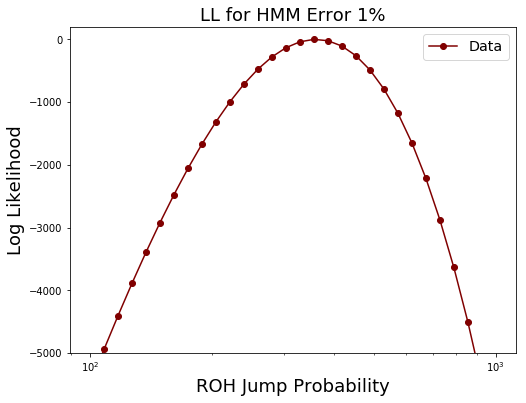

In [14]:
plot_ll_curve_roh_jumps(roh_jumps, ll_vec1, title="LL for HMM Error 1%", savepath = "./figures_test/ll_curve_ROH_jump_20phasedTSI_e01_rohin1000.pdf")

# Test different Error Rates for ML Parameter

In [16]:
%%time
### 3) Calculate LL for array of ROH Jump Rates
err_vec = np.logspace(-4,-1, 20)
prms_vec = [[1000, 1, 350, e] for e in err_vec]

procses = 10 # On Cluster
ll_vec_error = [-ll_mosaic_individuals(prms) for prms in prms_vec]  # Calculate full LL vector


Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 350.000
Error Rate: 0.0001
Mean LL: -4518.412867497719
STD LL: 196.5485086235587
Sum LL: -90368.25734995

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 350.000
Error Rate: 0.0001
Mean LL: -4514.85765961659
STD LL: 195.4541335042701
Sum LL: -90297.15319233

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 350.000
Error Rate: 0.0002
Mean LL: -4512.095918254565
STD LL: 194.33357707234427
Sum LL: -90241.91836509

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 350.000
Error Rate: 0.0003
Mean LL: -4510.675213290704
STD LL: 193.1876322179783
Sum LL: -90213.50426581

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 350.000
Error Rate: 0.0004
Mean LL: -4511.415314453656
STD LL: 192.00807842327626
Sum LL: -90228.30628907

Parameters Current Step:
ROH In 1000.000
ROH Out 1.000
ROH Jump: 350.000
Error Rate: 0.0006
Mean LL: -4515.5363965475835
STD LL: 190.7684101863

In [17]:
def plot_ll_curve_errors(error_vec, ll_vec1, title="", savepath=""):
    """Plot Likelihood curve."""
    fs = 18
    true_val = 0.1

    ll_vec = np.array(ll_vec1)
    ll_plot = ll_vec - np.max(ll_vec)
    i = np.argmax(ll_plot)

    print(f"Maximum Likelihood at {error_vec[i]} : {ll_vec[i]}")

    plt.figure(figsize=(8,6))
    plt.plot(error_vec, ll_plot, "o-", color="maroon", label="Data")
    plt.xscale("log")
    plt.ylabel("Log Likelihood", fontsize=fs)
    plt.xlabel("Error Rate", fontsize=fs)
    #plt.axvline(x=0.1, linewidth=3, color="lawngreen", label="True Value")
    #plt.axhline(y=-2, label="LL=-2", color="gray", zorder=0)
    plt.legend(fontsize=fs*0.8)
    plt.ylim([-5000,200])
    plt.title("LogLikelihood for Li & Stephens of 20 TSI")
    
    if len(title)>0:  # Set Title if given
        plt.title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

    plt.show()

Maximum Likelihood at 0.00029763514416313193 : -90213.50426581407


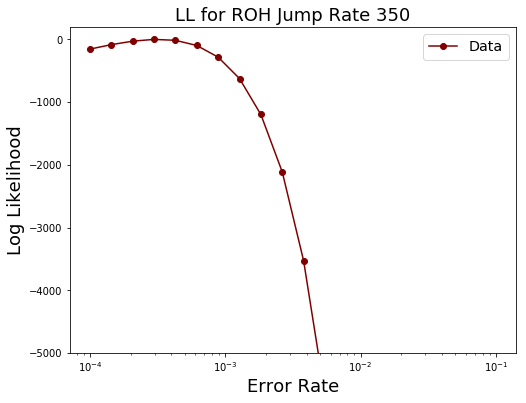

In [20]:
plot_ll_curve_errors(err_vec, ll_vec_error, title="LL for ROH Jump Rate 350", savepath="")

# Area51

### Plot of LL Copying with unphased data 
(should be much lower LL and peak at higher ROH-Jump)

Maximum Likelihood at 379.26901907322497 : -91102.36189653994
Maximum Likelihood at 1000.0 : -568815.9494010495


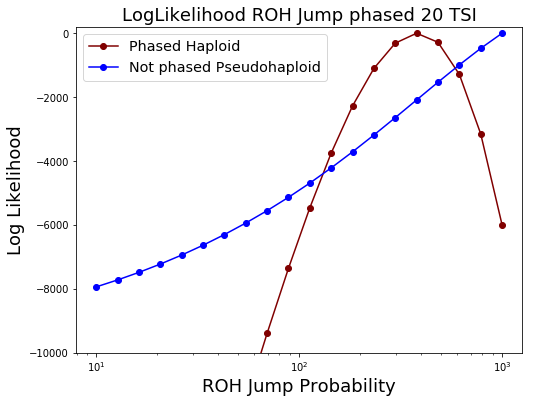

In [32]:
fs = 18
true_val = 0.1

ll_plot = ll_vec - np.max(ll_vec)
ll_plot1 = ll_vec1 - np.max(ll_vec1)
i = np.argmax(ll_plot)
i1 = np.argmax(ll_plot1)

print(f"Maximum Likelihood at {roh_jumps[i]} : {ll_vec[i]}")
print(f"Maximum Likelihood at {roh_jumps[i1]} : {ll_vec1[i]}")

plt.figure(figsize=(8,6))
plt.plot(roh_jumps, ll_plot, "o-", color="maroon", label="Phased Haploid")
plt.plot(roh_jumps, ll_plot1, "o-", color="blue", label="Not phased Pseudohaploid")

plt.xscale("log")
plt.ylabel("Log Likelihood", fontsize=fs)
plt.xlabel("ROH Jump Probability", fontsize=fs)
#plt.axvline(x=0.1, linewidth=3, color="lawngreen", label="True Value")
#plt.axhline(y=-2, label="LL=-2", color="gray", zorder=0)
plt.legend(fontsize=fs*0.8)
plt.ylim([-10000,200])
plt.title("LogLikelihood ROH Jump phased 20 TSI", fontsize=fs)
#plt.savefig("../figures_test/ll_curveSardX.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()